<a href="https://colab.research.google.com/github/vpcano/CAP_P2/blob/main/Ej1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p cuda
!rm -rf cuda/*

In [2]:
%%writefile cuda/stencil_1d_cpu.cu
    #include <iostream>
    #include <algorithm>
    #include <sys/time.h>
    using namespace std;

    #define RADIUS 3

    void stencil_1D(int *in, int *out, int N) {
        for (int i=0; i<N; i++) {
            out[i] = 0;
            for (int offset=-RADIUS; offset<=RADIUS; offset++) {
                out[i] += in[i+offset];
            }
        }
    }


    void fill_ints(int *x, int n) {
        fill_n(x, n, 1);
    }

    int main(int argc, char *argv[]) {
        int *in, *out;
        int N, size;
        struct timeval t1, t2;
        double t_total;

        if (argc < 2) {
            printf("Error: you must indicate the length of the array\n");
            return 1;
        }

        N = atoi(argv[1]);
        size = (N + 2*RADIUS) * sizeof(int);

        in = (int*) malloc(size);
        out = (int*) malloc(size);
        fill_ints(in, N + 2*RADIUS);
        fill_ints(out, N + 2*RADIUS);

        gettimeofday(&t1, NULL);
        stencil_1D(in + RADIUS, out + RADIUS, N);
        gettimeofday(&t2, NULL);

        /*
        printf("Output: \n");
        for (int i=0; i<N+2*RADIUS; i++) {
            printf("%d ", out[i]);
        }
        printf("\n");
        */
        t_total = (t2.tv_sec - t1.tv_sec)*1000000.0 + (t2.tv_usec - t1.tv_usec);
        printf("%d\t%f\n", N, t_total);

        free(in);
        free(out);
        return 0;
    }

Writing cuda/stencil_1d_cpu.cu


In [3]:
!nvcc cuda/stencil_1d_cpu.cu -o cuda/stencil_1d_cpu
!./cuda/stencil_1d_cpu 10000000


10000000	321804.000000


In [62]:
%%writefile cuda/stencil_1d_gpu.cu
    #include <iostream>
    #include <algorithm>
    #include <sys/time.h>
    #include "cuda.h"
    #include "cuda_runtime.h"
    using namespace std;

    #define RADIUS 3
    #define BLOCK_SIZE 16

    __global__ void stencil_1D(int *in, int *out, int N) {
        __shared__ int temp[BLOCK_SIZE + 2*RADIUS];
        int gindex = threadIdx.x + blockIdx.x*blockDim.x;
        int lindex = threadIdx.x + RADIUS;

        if (threadIdx.x < RADIUS) {
            if (gindex < RADIUS) {
                temp[lindex - RADIUS] = 0;
            }
            else {
                temp[lindex - RADIUS] = in[gindex - RADIUS];
            }
            if (gindex + BLOCK_SIZE < N) {
                temp[lindex + BLOCK_SIZE] = in[gindex + BLOCK_SIZE];
            }
            else {
                temp[lindex + BLOCK_SIZE] = 0;
            }
        }

        if (gindex < N) {

            temp[lindex] = in[gindex];

            __syncthreads();

            int result = 0;
            for (int offset=-RADIUS; offset<=RADIUS; offset++) {
                result += temp[lindex + offset];
            }

            out[gindex] = result;
        }
    }


    void fill_ints(int *x, int n) {
        fill_n(x, n, 1);
    }

    int main(int argc, char *argv[]) {
        int *h_in, *h_out;
        int *d_in, *d_out;
        int N, size;
        struct timeval t1, t2;
        double t_total;

        if (argc < 2) {
            printf("Error: you must indicate the length of the array\n");
            return 1;
        }

        N = atoi(argv[1]);
        size = N * sizeof(int);

        h_in = (int*) malloc(size);
        h_out = (int*) malloc(size);
        fill_ints(h_in, N);
        fill_ints(h_out, N);

        cudaMalloc((void**) &d_in, size);
        cudaMalloc((void**) &d_out, size);

        gettimeofday(&t1, NULL);
        cudaMemcpy(d_in, h_in, size, cudaMemcpyHostToDevice);
        cudaMemcpy(d_out, h_out, size, cudaMemcpyHostToDevice);

        stencil_1D<<<(N+BLOCK_SIZE-1)/BLOCK_SIZE,BLOCK_SIZE>>>(d_in, d_out, N);

        cudaMemcpy(h_out, d_out, size, cudaMemcpyDeviceToHost);

        gettimeofday(&t2, NULL);

        printf("Output: \n");
        for (int i=0; i<N; i++) {
            printf("%d ", h_out[i]);
        }
        printf("\n");

        t_total = (t2.tv_sec - t1.tv_sec)*1000000.0 + (t2.tv_usec - t1.tv_usec);
        printf("%d\t%f\n", N, t_total);

        free(h_in);
        free(h_out);
        cudaFree(d_in);
        cudaFree(d_out);
        return 0;
    }

Overwriting cuda/stencil_1d_gpu.cu


In [63]:
!nvcc cuda/stencil_1d_gpu.cu -o cuda/stencil_1d_gpu
!./cuda/stencil_1d_gpu 113


Output: 
4 5 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 6 5 4 
113	76.000000


In [6]:
!nvcc cuda/stencil_1d_cpu.cu -o cuda/stencil_1d_cpu
!nvcc cuda/stencil_1d_gpu.cu -o cuda/stencil_1d_gpu

In [42]:
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

tam_ini = 10**5
tam_fin = 10**6

N = tam_ini
data= list()
speedup = list()

while N <= tam_fin:
    execution_time_cpu_list = list()
    execution_time_gpu_list = list()

    for i in range(100):
        result_cpu = subprocess.run(["./cuda/stencil_1d_cpu" , str(N)], stdout=subprocess.PIPE, text=True)
        result_gpu = subprocess.run(["./cuda/stencil_1d_gpu" , str(N)], stdout=subprocess.PIPE, text=True)

        line_cpu = result_cpu.stdout.strip()
        columns_cpu = line_cpu.split()

        line_gpu = result_gpu.stdout.strip()
        columns_gpu = line_gpu.split()

        execution_time_cpu_list.append(float(columns_cpu[1]))
        execution_time_gpu_list.append(float(columns_gpu[1]))


    cpu_min = np.array(execution_time_cpu_list).mean()
    gpu_min = np.array(execution_time_gpu_list).mean()
    data.append({'N': N, 'execution_time_cpu': cpu_min, 'execution_time_gpu': gpu_min})
    speedup.append({'N': N, 'speedup': cpu_min/gpu_min})

    N = N + tam_ini

df = pd.DataFrame(data)

df_speedup = pd.DataFrame(speedup)
print(df)


         N  execution_time_cpu  execution_time_gpu
0   100000             2265.99              444.85
1   200000             4466.33              863.06
2   300000             7168.15             1168.41
3   400000             8794.38             1393.14
4   500000            12553.78             1790.17
5   600000            14074.95             2051.95
6   700000            15343.74             2344.97
7   800000            17414.70             2659.09
8   900000            19833.94             2874.48
9  1000000            23058.07             3236.98


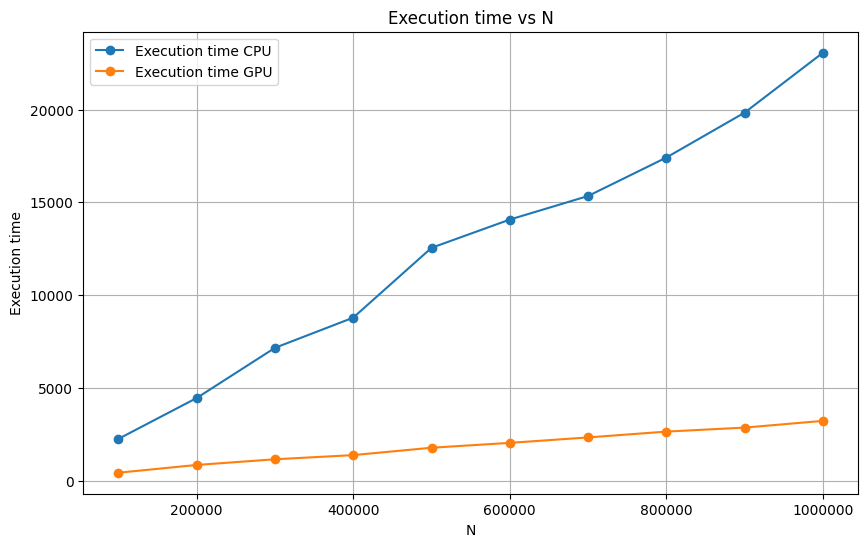

In [43]:
# Graficar los datos
plt.figure(figsize=(10, 6))
plt.plot(df['N'], df['execution_time_cpu'], label='Execution time CPU', marker='o')
plt.plot(df['N'], df['execution_time_gpu'], label='Execution time GPU', marker='o')
plt.xlabel('N')
plt.ylabel('Execution time')
plt.title('Execution time vs N')
plt.ticklabel_format(style='plain', axis='x')
plt.legend()
plt.grid(True)
plt.show()

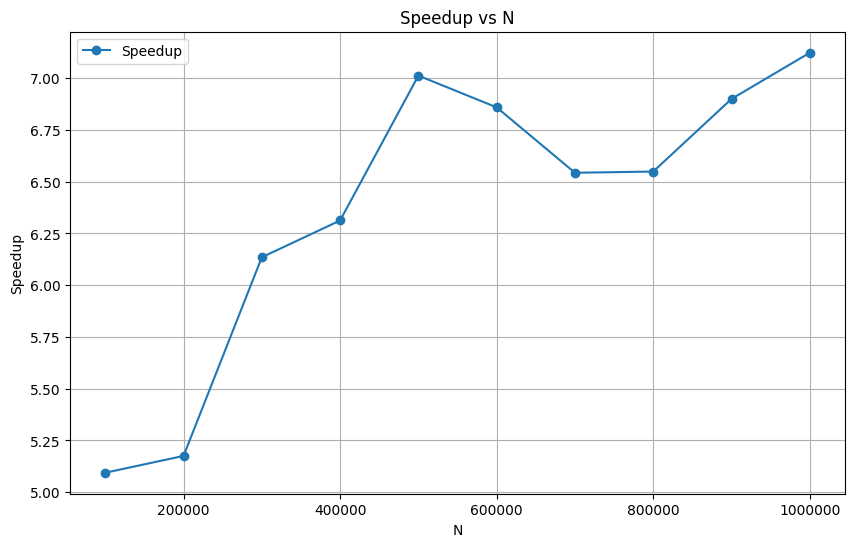

In [44]:
# Graficar los datos
plt.figure(figsize=(10, 6))
plt.plot(df['N'], df_speedup['speedup'], label='Speedup', marker='o')
plt.xlabel('N')
plt.ticklabel_format(style='plain', axis='x')
plt.ylabel('Speedup')
plt.title('Speedup vs N')
plt.legend()
plt.grid(True)
plt.show()